In [17]:
import time
from contextlib import contextmanager
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
)

import torch

from tqdm import tqdm  # Add tqdm for progress bar
from itertools import product

# RelBench
from relbench.datasets import get_dataset
from relbench.tasks import get_task

import relbench.metrics
import inspect

# TabPFN
from tabpfn import TabPFNClassifier, TabPFNRegressor

# Device preference
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# Define global dataset variable
DATASET = "rel-f1"


Using device: mps


In [18]:
# Patch relbench.metrics.skm.mean_squared_error to local mean_squared_error
relbench.metrics.skm.mean_squared_error = mean_squared_error

def patched_rmse(true, pred):
    if "squared" in inspect.signature(mean_squared_error).parameters:
        return mean_squared_error(true, pred, squared=False)
    else:
        return np.sqrt(mean_squared_error(true, pred))

relbench.metrics.rmse = patched_rmse

In [19]:
@contextmanager
def elapsed_timer():
    start = time.perf_counter()
    yield lambda: time.perf_counter() - start

def classification_metrics(y_true, y_pred, y_prob=None) -> Dict[str, float]:
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }
    if y_prob is not None:
        try:
            out["roc_auc"] = roc_auc_score(y_true, y_prob)
        except Exception:
            out["roc_auc"] = np.nan
    else:
        out["roc_auc"] = np.nan
    return out

def regression_metrics(y_true, y_pred, y_prob=None) -> Dict[str, float]:
    # Accepts y_prob for compatibility, but ignores it
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
    }

dataset = get_dataset(DATASET)
db = dataset.get_db()

def to_pandas(table):
    if hasattr(table, "to_pandas"):
        return table.to_pandas()
    if hasattr(table, "df"):
        return table.df
    raise ValueError("Unknown table type")

# Convert all tables to pandas DataFrames
tables = {}
for name in db.table_dict:
    tables[name] = to_pandas(db.table_dict[name])

for t in tables.values():
    for col in t.columns:
        if "date" in col.lower():
            t[col] = pd.to_datetime(t[col], errors="coerce")

In [20]:
def run_single_table_experiment(task_name: str):
    global prob_val, prob_test
    task = get_task(DATASET, task_name)

    # Create a training, validation, and test splits
    train_table = task.get_table("train")
    val_table = task.get_table("val")
    test_table = task.get_table("test", mask_input_cols=False)

    # Input features need to be numeric, otherwise encoded
    df = train_table.df
    df = df.sample(n=min(1000, len(df)), random_state=42)
    X_train = df.drop(columns=[task.target_col]).select_dtypes(include=[np.number])
    y_train = df[task.target_col]

    df = val_table.df
    df = df.sample(n=min(1000, len(df)), random_state=42)
    X_val = df.drop(columns=[task.target_col]).select_dtypes(include=[np.number])
    y_val = df[task.target_col]

    # For the test set, we do not sample to keep the full dataset
    df = test_table.df
    X_test = df.drop(columns=[task.target_col]).select_dtypes(include=[np.number])
    y_test = df[task.target_col]

    if task_name == "driver-position":
        # Depending on the task, TabPFNClassifier or TabPFNRegressor is used
        model = TabPFNRegressor(device=DEVICE)
        metric_fn = regression_metrics
        prob_val = prob_test = None
    else:
        model = TabPFNClassifier(device=DEVICE, ignore_pretraining_limits=True)
        metric_fn = classification_metrics

    with elapsed_timer() as t:
        model.fit(X_train, y_train)
    fit_time = t()

    with elapsed_timer() as t:
        y_val_pred = model.predict(X_val)
    pred_time_val = t()

    with elapsed_timer() as t:
        y_test_pred = model.predict(X_test)
    pred_time_test = t()

    if task_name != "driver-position":
        try:
            prob_val  = model.predict_proba(X_val)[:, 1]
            prob_test = model.predict_proba(X_test)[:, 1]
        except Exception:
            prob_val = prob_test = None

    # Get only the primary metric value (not dict)
    if task_name != "driver-position":
        primary_metric_val = list(task.evaluate(
            prob_val if prob_val is not None else y_val_pred,
            target_table=task.get_table("val", mask_input_cols=False)
        ).values())[0]
        primary_metric_test = list(task.evaluate(
            prob_test if prob_test is not None else y_test_pred,
            target_table=task.get_table("test", mask_input_cols=False)
        ).values())[0]
    else:
        primary_metric_val = np.nan
        primary_metric_test = np.nan

    res = {
        "val": {
            **metric_fn(y_val, y_val_pred, prob_val),
            "fit_time": fit_time,
            "predict_time": pred_time_val,
            "primary_metric_relbench": primary_metric_val,
        },
        "test": {
            **metric_fn(y_test, y_test_pred, prob_test),
            "fit_time": fit_time,
            "predict_time": pred_time_test,
            "primary_metric_relbench": primary_metric_test,
        }
    }
    return res

In [21]:
# Create features for drivers based on their past performance
# This function creates features like average position, points, DNF rate, and average laps
def engineer_driver_features():
    # Extract the race dates and results
    results = tables["results"].merge(
        tables["races"][["raceId", "date"]],
        on="raceId", how="left"
    )

    print("results columns after merge:", results.columns.tolist())
    print("Number of rows after merge:", results.shape[0])
    results = results.dropna(subset=["driverId", "date_y"])
    print("Number of rows after dropna:", results.shape[0])

    # Create a did not finish (DNF) flag as indicator for future race outcomes
    results["dnf_flag"] = (~results["positionOrder"].isna()).astype(int)
    # For each driver, calculate the average position, points, DNF rate, and average laps
    # Only the information before the current race is used
    feats = results.groupby("driverId").expanding().agg({
        "positionOrder": "mean",
        "points": "mean",
        "dnf_flag": "mean",
        "laps": "mean"
    }).reset_index()
    feats = feats.rename(columns={
        "positionOrder": "avg_position",
        "points": "avg_points",
        "dnf_flag": "dnf_rate",
        "laps": "avg_laps"
    })
    feats["date"] = results["date_y"].values
    return feats

driver_feats = engineer_driver_features()

results columns after merge: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionOrder', 'points', 'laps', 'milliseconds', 'fastestLap', 'rank', 'statusId', 'date_x', 'date_y']
Number of rows after merge: 20323
Number of rows after dropna: 20323


In [22]:
def run_merged_table_experiment(task_name: str):
    global prob_val, prob_test
    task = get_task(DATASET, task_name)

    train_table = task.get_table("train")
    val_table = task.get_table("val")
    test_table = task.get_table("test", mask_input_cols=False)

    df_train = train_table.df
    df_train = df_train.sample(n=min(1000, len(df_train)), random_state=42)
    idx_train = list(zip(df_train["driverId"], df_train["date"]))
    X_train = df_train.drop(columns=[task.target_col]).select_dtypes(include=[np.number])
    y_train = df_train[task.target_col]

    df_val = val_table.df
    df_val = df_val.sample(n=min(1000, len(df_val)), random_state=42)
    idx_val   = list(zip(df_val["driverId"], df_val["date"]))
    X_val = df_val.drop(columns=[task.target_col]).select_dtypes(include=[np.number])
    y_val = df_val[task.target_col]

    # For the test set, we do not sample to keep the full dataset
    df_test = test_table.df
    idx_test  = list(zip(df_test["driverId"], df_test["date"]))
    X_test = df_test.drop(columns=[task.target_col]).select_dtypes(include=[np.number])
    y_test = df_test[task.target_col]

    # Merge features by driverId and date (backward asof join)
    # backward asof join finds the last row in the other table where
    # the time is less than or equal to the time in the current row of the self table
    def enrich(X, idx):
        df = X.copy()
        # Create a DataFrame with driverId and date for each row
        idx_df = pd.DataFrame(idx, columns=["driverId", "date"]) # create DataFrame from tuples
        idx_df["driverId"] = idx_df["driverId"].astype("int64")
        idx_df["date"] = pd.to_datetime(idx_df["date"]) # ensure date is in datetime format
        driver_feats_fixed = driver_feats.copy()
        driver_feats_fixed["driverId"] = driver_feats_fixed["driverId"].astype("int64")
        # Use backward asof merge to align features with the closest previous date
        merged = pd.merge_asof(
            idx_df.sort_values("date"),
            driver_feats_fixed.sort_values("date"),
            on="date", by="driverId",
            direction="backward", tolerance=pd.Timedelta("3650D") # 10 years tolerance
        )
        merged = merged.drop(columns=["driverId", "date"]) # already present in df
        df = pd.concat([df.reset_index(drop=True), merged.reset_index(drop=True)], axis=1)
        return df

    X_train_en = enrich(X_train, idx_train)
    X_val_en   = enrich(X_val, idx_val)
    X_test_en  = enrich(X_test, idx_test)

    if task_name == "driver-position":
        model = TabPFNRegressor(device=DEVICE)
        metric_fn = regression_metrics
        prob_val = prob_test = None
    else:
        model = TabPFNClassifier(device=DEVICE)
        metric_fn = classification_metrics

    with elapsed_timer() as t:
        model.fit(X_train_en, y_train)
    fit_time = t()

    with elapsed_timer() as t:
        y_val_pred = model.predict(X_val_en)
    pred_time_val = t()

    with elapsed_timer() as t:
        y_test_pred = model.predict(X_test_en)
    pred_time_test = t()

    if task_name != "driver-position":
        try:
            prob_val  = model.predict_proba(X_val_en)[:, 1]
            prob_test = model.predict_proba(X_test_en)[:, 1]
        except Exception:
            prob_val = prob_test = None

    if task_name != "driver-position":
        primary_metric_val = list(task.evaluate(
            prob_val if prob_val is not None else y_val_pred,
            target_table=task.get_table("val", mask_input_cols=False)
        ).values())[0]
        primary_metric_test = list(task.evaluate(
            prob_test if prob_test is not None else y_test_pred,
            target_table=task.get_table("test", mask_input_cols=False)
        ).values())[0]
    else:
        primary_metric_val = np.nan
        primary_metric_test = np.nan

    res = {
        "val": {
            **metric_fn(y_val, y_val_pred, prob_val),
            "fit_time": fit_time,
            "predict_time": pred_time_val,
            "primary_metric_relbench": primary_metric_val,
        },
        "test": {
            **metric_fn(y_test, y_test_pred, prob_test),
            "fit_time": fit_time,
            "predict_time": pred_time_test,
            "primary_metric_relbench": primary_metric_test,
        }
    }
    return res


In [23]:
# TASKS = ["driver-dnf", "driver-top3", "driver-position"]
TASKS = ["driver-dnf"]

all_results_long = []

def results_to_long(task, setting, split, metrics):
    rows = []
    for metric_name, value in metrics.items():
        # Only add row if value is not None and not NaN
        if value is not None and not (isinstance(value, float) and np.isnan(value)):
            rows.append({
                "dataset": DATASET,  # Fill with DATASET variable
                "task": task,
                "split": split,
                "setting": setting,
                "method": "TabPFN_experiment_v1.0",
                "metric": metric_name,
                "score": value
            })
    return rows

# Use tqdm to show progress bar for tasks and settings
for task in tqdm(TASKS, desc="Tasks"):
    task_setting_pairs = list(product(TASKS, [("single", run_single_table_experiment), ("merged", run_merged_table_experiment)]))

    for (task, (setting, run_fn)) in tqdm(task_setting_pairs, desc="Task/Setting pairs"):
        res = run_fn(task)
        for split, metrics in res.items():
            all_results_long.extend(results_to_long(task, setting, split, metrics))

results_long_df = pd.DataFrame(all_results_long)
# Ensure 'dataset' is the first column
cols = ["dataset"] + [col for col in results_long_df.columns if col != "dataset"]
results_long_df = results_long_df[cols]
# Round all numerical values in 'score' to 4 decimal places
results_long_df["score"] = results_long_df["score"].apply(lambda x: round(x, 4) if isinstance(x, (float, int, np.floating, np.integer)) else x)

results_long_df.to_csv("results_summary_long.csv", index=False)
results_long_df

Tasks: 100%|██████████| 1/1 [09:00<00:00, 540.12s/it]


,dataset,task,split,setting,method,metric,score
0,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,accuracy,0.7792
1,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,f1_macro,0.4379
2,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,roc_auc,0.6393
3,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,fit_time,1.6596
4,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,predict_time,63.2011
5,rel-f1,driver-dnf,val,single,TabPFN_experiment_v1.0,primary_metric_relbench,0.8072
6,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,accuracy,0.7051
7,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,f1_macro,0.4135
8,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,roc_auc,0.6432
9,rel-f1,driver-dnf,test,single,TabPFN_experiment_v1.0,fit_time,1.6596


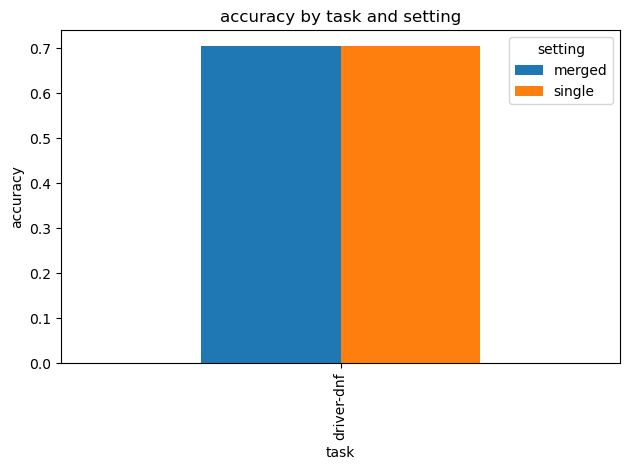

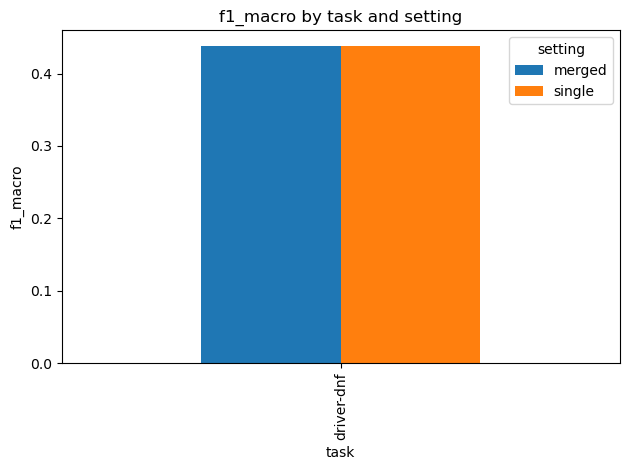

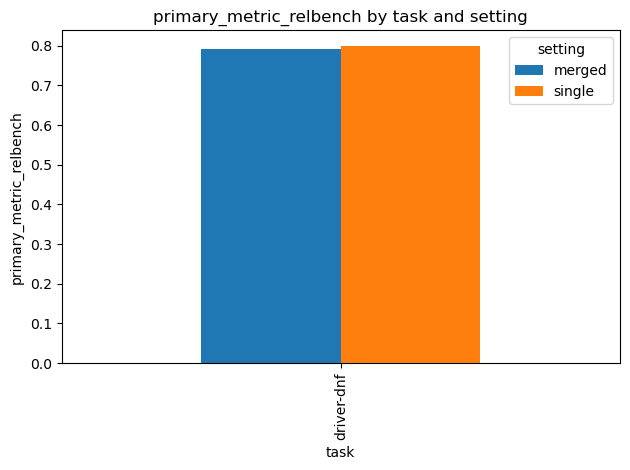

In [24]:
def plot_metric(metric, split=None, setting=None):
    """
    Plot the given metric from results_long_df.
    Optionally filter by split and/or setting.
    """
    df = results_long_df[results_long_df["metric"] == metric]
    if split is not None:
        df = df[df["split"] == split]
    if setting is not None:
        df = df[df["setting"] == setting]
    if df.empty:
        print(f"No data for metric: {metric}, split: {split}, setting: {setting}")
        return
    ax = df.pivot(index="task", columns="setting", values="score").plot(kind="bar")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by task and setting")
    ax.legend(title="setting")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metric("accuracy", split="test")
plot_metric("f1_macro", split="val")
plot_metric("primary_metric_relbench", split="test")
